In [3]:
import re
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import joblib

# --- Load your dataset (already done before) ---_train.csv"
file_path = "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/reaction_templates_50k_train.csv"
df = pd.read_csv(file_path, sep="\t")

colonnes_necessaires = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']
df = df[colonnes_necessaires]
df_unique = df.drop_duplicates(subset=['PseudoHash'], keep='first')

# --- 1. Remove atom mapping ---

def remove_atom_mapping(smiles):
    """Remove :number mapping from SMILES."""
    return re.sub(r":\d+", "", smiles)

# --- 2. Split SMILES into reactants and products ---

def split_rxn_smiles(rxn_smiles):
    try:
        parts = rxn_smiles.split(">>")
        if len(parts) != 2:
            return [], []
        reactants_raw, products_raw = parts
        reactants = reactants_raw.split(".")
        products = products_raw.split(".")
        return reactants, products
    except Exception as e:
        print(f"Erreur dans split_rxn_smiles: {rxn_smiles} -> {e}")
        return [], []

# --- 3. Convert SMILES to fingerprints (after cleaning) ---

def smiles_to_fingerprints(smiles):
    try:
        reactants_smiles, products_smiles = split_rxn_smiles(smiles)

        def mols_to_fps(smiles_list):
            fps = []
            n_bits = 2048
            for s in smiles_list:
                cleaned_s = remove_atom_mapping(s)
                mol = Chem.MolFromSmiles(cleaned_s)
                if mol is None:
                    print(f"Molécule invalide : {s}")
                    continue  # <-- SKIP invalid molecules
                fp = AllChem.GetMorganFingerprint(mol, radius=3)
                arr = np.zeros((n_bits,), dtype=int)
                if isinstance(fp, Chem.DataStructs.UIntSparseIntVect):
                    on_bits = list(fp.GetNonzeroElements().keys())
                    for bit in on_bits:
                        arr[bit % n_bits] = 1
                fps.append(arr)
            return fps

        reactants_fps = mols_to_fps(reactants_smiles)
        products_fps = mols_to_fps(products_smiles)

        return reactants_fps, products_fps

    except Exception as e:
        print(f"Erreur parsing SMILES: {smiles} -> {e}")
        return [], []

# --- 4. Prepare training data X, y ---

def prepare_fingerprints_for_training(df):
    X = []
    y = []
    
    print("Début du traitement des données.")
    
    for idx, (smiles, target) in enumerate(zip(df['RxnSmilesClean'], df['TemplateHash'])):
        # Affichage des premières lignes pour vérifier les données
        if idx < 5:  # Afficher seulement les 5 premières lignes pour déboguer
            print(f"Index {idx} - SMILES: {smiles} | Target: {target}")
        
        reactants_fps, products_fps = smiles_to_fingerprints(smiles)
        
        if reactants_fps and products_fps:
            X.extend(reactants_fps)
            y.extend([target] * len(reactants_fps))
            X.extend(products_fps)
            y.extend([target] * len(products_fps))
        else:
            print(f"Skipping reaction at index {idx}: {smiles}")

    X = np.array(X)
    y = np.array(y)

    print(f"Fingerprint preparation finished. Total examples: {X.shape[0]}")
    if X.shape[0] != y.shape[0]:
        raise ValueError(f"Mismatch: X {X.shape[0]} vs y {y.shape[0]}")

    return X, y

In [7]:
import pandas as pd

# Chemins des fichiers
paths = {
    "train": "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/reaction_templates_50k_train.csv",
    "val": "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/reaction_templates_50k_valid.csv",
    "test": "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/reaction_templates_50k_test.csv"
}


# Colonnes attendues
required_cols = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']

dfs = []

# Charger et vérifier les fichiers
for name, path in paths.items():
    try:
        df = pd.read_csv(path, sep="\t")  # Charger le fichier CSV avec le séparateur tabulation
        df.columns = df.columns.str.strip()  # Supprimer les espaces dans les noms de colonnes

        # Vérifier que toutes les colonnes nécessaires sont présentes
        missing_cols = set(required_cols) - set(df.columns)
        if missing_cols:
            print(f"⚠️  Colonnes manquantes dans {name} : {missing_cols}")
            continue  # Passer ce fichier si des colonnes sont manquantes

        dfs.append(df[required_cols])
        print(f"✅ {name} chargé avec succès.")
        
    except Exception as e:
        print(f"❌ Erreur lors du chargement de {name} : {e}")

# Fusionner les fichiers valides
if dfs:
    # Fusionner les fichiers et supprimer les doublons sur 'PseudoHash'
    combined_df = pd.concat(dfs, axis=0).drop_duplicates(subset=['PseudoHash'])

    # Sauvegarder le fichier combiné avec séparateur tabulation
    combined_df.to_csv("/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv", index=False, sep="\t")
    print("✅ Données fusionnées et sauvegardées dans 'combined_data.csv'")
else:
    print("❌ Aucun fichier valide à fusionner.")

# Charger et préparer le fichier combiné
file_path = "/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv"

# Charger le fichier combiné avec séparateur tabulation
combined_df = pd.read_csv(file_path, sep="\t")  # Note : c'est une tabulation pour la lecture de combined_data.csv
combined_df.columns = combined_df.columns.str.strip()  # Nettoyer les espaces dans les noms de colonnes

# Vérification des colonnes
print(f"Colonnes de combined_df : {combined_df.columns}")


✅ train chargé avec succès.
✅ val chargé avec succès.
✅ test chargé avec succès.
✅ Données fusionnées et sauvegardées dans 'combined_data.csv'
Colonnes de combined_df : Index(['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash'], dtype='object')


📁 Étape 1 : Chargement du dataset...
🔬 Étape 3 : Transformation des données...
Début du traitement des données.
Index 0 - SMILES: CC(C)(C)OC(=O)[NH:1][C@H:2]([CH2:3][c:4]1[cH:5][nH:6][c:7]2[cH:8][cH:9][cH:10][cH:11][c:12]12)[c:13]1[n:14][c:15](-[c:16]2[cH:17][cH:18][c:19]([F:20])[cH:21][cH:22]2)[cH:23][nH:24]1>>[NH2:1][C@H:2]([CH2:3][c:4]1[cH:5][nH:6][c:7]2[cH:8][cH:9][cH:10][cH:11][c:12]12)[c:13]1[n:14][c:15](-[c:16]2[cH:17][cH:18][c:19]([F:20])[cH:21][cH:22]2)[cH:23][nH:24]1 | Target: b883d4425d6daa76b98d429b998b1a6ca9aa33cb964e8a98b8b7708b2a9601a3
Index 1 - SMILES: CS(=O)(=O)O[CH2:1][C:2]1([NH:3][C:4]([O:5][C:6]([CH3:7])([CH3:8])[CH3:9])=[O:10])[CH2:11][O:12][C:13]([CH3:14])([CH3:15])[O:16][CH2:17]1.[CH3:18][O:19][c:20]1[cH:21][cH:22][c:23]2[c:24]([C:25](=[O:26])[c:27]3[cH:28][c:29]([O:30][CH3:31])[c:32]([O:33][CH3:34])[c:35]([O:36][CH3:37])[cH:38]3)[cH:39][nH:40][c:41]2[cH:42]1>>[CH2:1]([C:2]1([NH:3][C:4]([O:5][C:6]([CH3:7])([CH3:8])[CH3:9])=[O:10])[CH2:11][O:12][C:13]([CH3:14])([C

[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerator
[17:08:21] DEPRECATION WARNING: please use MorganGenerat

Fingerprint preparation finished. Total examples: 128853
✅ Étape 4 : Données transformées en X et y
🔍 Vérification des valeurs manquantes dans y...
✂️ Étape 5 : Split 70% train, 15% val, 15% test
🧹 Étape 6 : Stratification sur la partie temporaire...
📊 Taille des jeux : train=97740, val=15556, test=15557
✅ Étape 7 : Données normalisées
🚀 Étape 8 : Entraînement du modèle avec early stopping
Iteration 1, loss = 8.27917833
Validation score: 0.066708
Iteration 2, loss = 7.12767737
Validation score: 0.100471
Iteration 3, loss = 6.08264050
Validation score: 0.121342
Iteration 4, loss = 4.91666317
Validation score: 0.128300
Iteration 5, loss = 3.74825055
Validation score: 0.126253
Iteration 6, loss = 2.87375697
Validation score: 0.126663
Iteration 7, loss = 2.32186873
Validation score: 0.130448
Iteration 8, loss = 1.97044342
Validation score: 0.132699
Iteration 9, loss = 1.73677723
Validation score: 0.134745
Iteration 10, loss = 1.57285890
Validation score: 0.130857
Iteration 11, loss = 1.463

/var/folders/6p/bt64nngj239f0jv3rg46dlf40000gn/T/ipykernel_15193/1310067640.py:104: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/retrosynth-env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


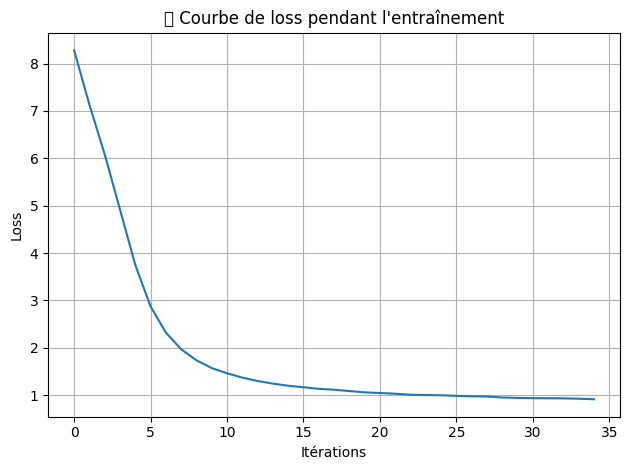

💾 Modèle et scaler sauvegardés !


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt

# 1. Charger le dataset
print("📁 Étape 1 : Chargement du dataset...")
combined_df = pd.read_csv("/Users/giuliogarotti/Documents/GitHub/Projet_chem/uspto50/uspto50/combined_data.csv", sep="\t")

# 2. Colonnes utiles
cols = ['RxnSmilesClean', 'PseudoHash', 'RetroTemplate', 'TemplateHash']

# 3. Transformation des données en X et y
print("🔬 Étape 3 : Transformation des données...")
X, y = prepare_fingerprints_for_training(combined_df)
print("✅ Étape 4 : Données transformées en X et y")

# 4. Encodage de y (s'il s'agit de labels catégoriels sous forme de chaînes)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Si y est sous forme de chaînes, cela le convertira en entiers

# Vérification et suppression des valeurs manquantes dans y
print("🔍 Vérification des valeurs manquantes dans y...")
if np.any(np.isnan(y)):
    print("⚠️ Valeurs manquantes trouvées dans y, suppression des lignes correspondantes...")
    mask_valid = ~np.isnan(y)
    X = X[mask_valid]
    y = y[mask_valid]

# 5. Split 70/15/15 (train/validation/test)
print("✂️ Étape 5 : Split 70% train, 15% val, 15% test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)

for train_idx, temp_idx in sss.split(X, y):
    X_train, X_temp = X[train_idx], X[temp_idx]
    y_train, y_temp = y[train_idx], y[temp_idx]

# 6. Stratification uniquement sur les classes fréquentes
# Identifier les classes rares ayant moins de 2 échantillons
rare_classes = [class_ for class_, count in pd.Series(y_temp).value_counts().items() if count == 1]

# Sélectionner les classes fréquentes (ayant au moins 2 échantillons)
frequent_classes = [class_ for class_ in pd.Series(y_temp).value_counts().index if class_ not in rare_classes]

# Transformer y_temp en pandas.Series pour pouvoir utiliser .isin()
y_temp_series = pd.Series(y_temp)

# Filtrer X_temp et y_temp pour ne garder que les classes fréquentes pour stratification
mask_frequent = y_temp_series.isin(frequent_classes)
X_temp_filtered = X_temp[mask_frequent]
y_temp_filtered = y_temp[mask_frequent]

# 7. Stratification sur la partie temporaire filtrée
print("🧹 Étape 6 : Stratification sur la partie temporaire...")
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)

for val_idx, test_idx in sss_val_test.split(X_temp_filtered, y_temp_filtered):
    X_val, X_test = X_temp_filtered[val_idx], X_temp_filtered[test_idx]
    y_val, y_test = y_temp_filtered[val_idx], y_temp_filtered[test_idx]

# 8. Inclure les classes rares dans l'entraînement sans stratification
X_train = np.vstack([X_train, X_temp[~mask_frequent]])  # Ajouter les classes rares dans le train
y_train = np.hstack([y_train, y_temp[~mask_frequent]])

print(f"📊 Taille des jeux : train={len(y_train)}, val={len(y_val)}, test={len(y_test)}")

# 9. Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print("✅ Étape 7 : Données normalisées")

# 10. Modèle avec early stopping
print("🚀 Étape 8 : Entraînement du modèle avec early stopping")
model = MLPClassifier(
    hidden_layer_sizes=(128, 128, 64),
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)
model.fit(X_train_scaled, y_train)
print("✅ Modèle entraîné")

# 11. Évaluation sur validation et test
acc_val = accuracy_score(y_val, model.predict(X_val_scaled))
acc_test = accuracy_score(y_test, model.predict(X_test_scaled))
print(f"📈 Accuracy validation: {acc_val:.4f}")
print(f"📉 Accuracy test: {acc_test:.4f}")

# 12. Courbe de loss
plt.plot(model.loss_curve_)
plt.title("📉 Courbe de loss pendant l'entraînement")
plt.xlabel("Itérations")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Sauvegarde du modèle et scaler
joblib.dump(model, 'mlp_classifier_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("💾 Modèle et scaler sauvegardés !")


In [9]:
import joblib

# Save the existing label_encoder object
joblib.dump(label_encoder, 'label_encoder.pkl')
print("✅ LabelEncoder saved to 'label_encoder.pkl'")


✅ LabelEncoder saved to 'label_encoder.pkl'
